In [1]:
%matplotlib inline
from pathlib import Path
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import scipy.stats as sstats

import datareader as reader
import epoch_analysis, kw_dunn

## Trial number

In [2]:
dataset_root = "../01_data/04_formatted"
figdir       = Path("../05_figures/01_asymmetry")
saved        = False

In [3]:
alltrials = reader.load_trials(dataset_root)
trials    = [trial for trial in alltrials if trial.has_eyedata()]

In [4]:
def get_info(trials):
    sessions = set((trial.subject, trial.session) for trial in trials)
    subjects = set(trial.subject for trial in trials)
    epochs   = sum(trial.states.shape[0] for trial in trials)
    return f"{len(trials)} trials out of {len(sessions)} sessions from {len(subjects)} subjects ({epochs} epochs)"

In [5]:
print("## Number of trials/epochs used for analysis\n")
print(f"- all annotated trials: {get_info(alltrials)}")
print(f"- trials with eye positions: {get_info(trials)}")

## Number of trials/epochs used for analysis

- all annotated trials: 113 trials out of 21 sessions from 4 subjects (876 epochs)
- trials with eye positions: 91 trials out of 17 sessions from 4 subjects (728 epochs)


## Average-trace figure

### Baseline subtraction

Adjust so that the range of values will be normalized to 1.

In [6]:
def normalize(vec, subtract_min=True):
    m = np.nanmin(vec)
    M = np.nanmax(vec)
    den = vec - m if subtract_min == True else vec
    return den / (M - m)

for trial in trials:
    for side in ("left", "right"):
        trial.tracking[f"{side}_whisker_normalized"] = normalize(trial.tracking[f"{side}_whisker_angle_deg"], subtract_min=False)

In [7]:
trials[0].tracking.head()

time  left_whisker_angle_deg  left_whisker_radius_px  \
0  0.000                3.513870              271.151556   
1  0.005                4.533231              272.785300   
2  0.010                5.875672              273.417605   
3  0.015                6.574637              271.189545   
4  0.020                6.493624              271.002909   

   left_pupil_normalized_position  left_pupil_normalized_diameter  \
0                        0.048674                        0.086702   
1                        0.048674                        0.086702   
2                        0.048674                        0.086702   
3                        0.048674                        0.086702   
4                        0.048674                        0.086702   

   right_whisker_angle_deg  right_whisker_radius_px  \
0                13.644373               243.731827   
1                14.096692               247.667480   
2                15.003054               248.133120   
3                15.494432               246.543158   
4                15.364230               246.802274   

   right_pupil_normalized_position  right_pupil_normalized_diameter  \
0                         0.056916                         0.097801   
1                         0.056916                         0.097801   
2                         0.056916                         0.097801   
3                         0.056916                         0.097801   
4                         0.056916                         0.097801   

   left_whisker_normalized  right_whisker_normalized  
0                 0.026068                  0.093315  
1                 0.033631                  0.096408  
2                 0.043590                  0.102607  
3                 0.048775                  0.105968  
4                 0.048174                  0.105077

### Collection of epochs: reproducing Ronny's way

In [8]:
def coef(epochs, state, attr, turn, side, normalize=True):
    # whisker: left - right (right turn) or right - left (left turn)
    # eye: (left + right)/2 (right turn) or -(left + right)/2 (left turn)
    b = 1 if (turn == "Right" or normalize == False) else -1
    if attr == "whisker":
        a = 1
        c = 1 if side == "left" else -1
    else:
        a = 0.5
        c = -1
    return a * b * c * epochs[state][attr][turn][side]
    
attrs = dict(whisker="{side}_whisker_normalized", # "_subtracted"
             eye="{side}_pupil_normalized_position")
turns = ("Left", "Right")
sides = ("left", "right")

In [9]:
# prepare a set of epochs for each state (with the specified pattern)

epochs = {}
for state, pattern in epoch_analysis.PATTERNS.items():
    epochs[state] = {}
    for name, attr in attrs.items():
        epochs[state][name] = {}
        for turn in turns:
            epochs[state][name][turn] = {}
            diff = None
            ndiff = None
            for side in sides:
                _epochs = epoch_analysis.collect_epochs_with_pattern(trials,
                                                                     pattern.format(turn=turn),
                                                                     property=attr.format(side=side))
                epochs[state][name][turn][side] = epoch_analysis.get_normalized_traces(_epochs)
                if diff is None:
                    diff = coef(epochs, state, name, turn, side, normalize=False)
                    ndiff = coef(epochs, state, name, turn, side, normalize=True)
                else:
                    diff = diff + coef(epochs, state, name, turn, side, normalize=False)
                    ndiff = ndiff + coef(epochs, state, name, turn, side, normalize=True)
            epochs[state][name][turn]["diff"] = diff
            epochs[state][name][turn]["ndiff"] = ndiff
        epochs[state][name]["Both"] = {
            'diff': np.concatenate([epochs[state][name][turn]["diff"] for turn in turns], axis=1),
            'ndiff': np.concatenate([epochs[state][name][turn]["ndiff"] for turn in turns], axis=1),
        }

In [10]:
# report numbers
print("## State-dependence statistics\n")
print("### Number of behavioral epochs used\n")
for state in epoch_analysis.PATTERNS.keys():
    print(f"- {state}: {epochs[state]['whisker']['Both']['diff'].shape[1]} epochs")

## State-dependence statistics

### Number of behavioral epochs used

- AtEnd: 90 epochs
- Backward: 90 epochs
- Turn: 92 epochs
- Forward: 113 epochs
- Expect: 89 epochs
- Lick: 87 epochs


## Trace figures

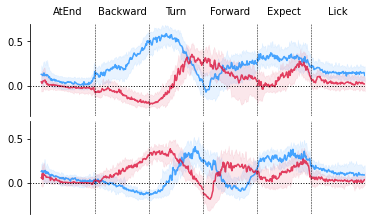

In [11]:
attr = 'whisker'
ymin, ymax = (-0.35, 0.7)
yticks     = (0, 0.5)
borders = np.linspace(0, 1, 101, endpoint=True)
x = (borders[1:] + borders[:-1]) / 2
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(6, 3))
for row, turn in enumerate(('Left', 'Right')):
    ax = axes[row]
    tickpos = []
    for offset, state in enumerate(epoch_analysis.STATES):
        for side, color in (("right", "dodgerblue"), ("left", "crimson")):
            v = epochs[state][attr][turn][side]
            m = np.median(v, axis=1)
            l = np.percentile(v, 25, axis=1)
            u = np.percentile(v, 75, axis=1)
            ax.plot(x+offset, m, lw=1.5, c=color, alpha=.8)
            ax.fill_between(x+offset, l, u, color=color, lw=.5, alpha=.1)
        tickpos.append(offset+0.5)
    ax.vlines(np.arange(1, len(epoch_analysis.STATES)), ymin, ymax, linewidth=.5, linestyles='dashed', color='k')
    ax.hlines(0, -.2, len(epoch_analysis.STATES), color='k', linewidth=1, linestyles='dotted')
    if row == 0:
        ax.set_xticks(tickpos)
        ax.set_xticklabels(epoch_analysis.STATES)
    for side in ("top", "right", "bottom"):
        ax.spines[side].set_visible(False)
    ax.tick_params(labelsize=10, bottom=False, labelbottom=False, labeltop=(row == 0))
plt.xlim(-.2, len(epoch_analysis.STATES))
plt.ylim(ymin, ymax)
plt.yticks(yticks)
plt.subplots_adjust(hspace=0.05, bottom=.02, top=.9)

if saved == True:
    figpath = figdir / "whisker-traces-summary.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
plt.show()

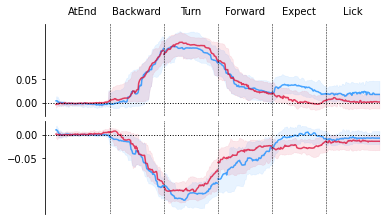

In [12]:
attr = 'eye'
ymin, ymax = (-0.2, 0.2)
yticks     = (0, 0.1)
borders = np.linspace(0, 1, 101, endpoint=True)
x = (borders[1:] + borders[:-1]) / 2
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 3))
for row, turn in enumerate(('Left', 'Right')):
    ax = axes[row]
    tickpos = []
    for offset, state in enumerate(epoch_analysis.STATES):
        for side, color in (("right", "dodgerblue"), ("left", "crimson")):
            v = epochs[state][attr][turn][side]
            m = np.median(v, axis=1)
            l = np.percentile(v, 25, axis=1)
            u = np.percentile(v, 75, axis=1)
            ax.plot(x+offset, m, lw=1.5, c=color, alpha=.8)
            ax.fill_between(x+offset, l, u, color=color, lw=.5, alpha=.1)
        tickpos.append(offset+0.5)
    ax.vlines(np.arange(1, len(epoch_analysis.STATES)), ymin, ymax, linewidth=.5, linestyles='dashed', color='k')
    ax.hlines(0, -.2, len(epoch_analysis.STATES), color='k', linewidth=1, linestyles='dotted')
    if row == 0:
        ax.set_xticks(tickpos)
        ax.set_xticklabels(epoch_analysis.STATES)
    for side in ("top", "right", "bottom"):
        ax.spines[side].set_visible(False)
    ax.tick_params(labelsize=10, bottom=False, labelbottom=False, labeltop=(row == 0))
plt.xlim(-.2, len(epoch_analysis.STATES))
axes[0].set_ylim(-0.03, 0.17)
axes[0].set_yticks((0, 0.05))
axes[1].set_ylim(-0.17, 0.03)
axes[1].set_yticks((-0.05, 0))
plt.subplots_adjust(hspace=0.05, bottom=.02, top=.9)

if saved == True:
    figpath = figdir / "pupil-traces-summary.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
plt.show()

## Summary figures

In [13]:
summary = {}
for attr in ("whisker", "eye"):
    summary[attr] = {}
    for state in epoch_analysis.STATES:
        summary[attr][state] = {}
        for turn in ('Left', 'Right', 'Both'):
            avg   = np.median(epochs[state][attr][turn]["ndiff"], axis=0)
            half1 = np.median(epochs[state][attr][turn]["ndiff"][:50,:], axis=0)
            half2 = np.median(epochs[state][attr][turn]["ndiff"][50:,:], axis=0)
            summary[attr][state][turn] = np.stack([avg, half1, half2], axis=0)

In [14]:
class BoxSummary(namedtuple('_BoxSummary', ('n', 'q1', 'q2', 'q3', 'min', 'max', 'outliers'))):
    @classmethod
    def from_values(cls, values):
        values = values[~np.isnan(values)]
        n  = values.size
        q1 = np.percentile(values, 25)
        q2 = np.median(values)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        vmin  = values[values >= lower].min()
        vmax  = values[values <= upper].max()
        outliers = values[np.logical_or(values < vmin, values > vmax)]
        return cls(n, q1, q2, q3, vmin, vmax, outliers)

def plot_box_around(x, boxsummary, ax=None, color='gray', mcolor='w', ecolor='k', ocolor='k',
                    boxwidth=.5, mlinewidth=1.5, elinewidth=1, marker='o', markersize=2, boxalpha=.6):
    v = boxsummary
    if ax is None:
        ax = plt.gca()
    ax.add_patch(Rectangle((x-boxwidth/2,v.q1), boxwidth, v.q3-v.q1, color=color, linewidth=0, alpha=boxalpha))
    ax.hlines(v.q2, x-boxwidth*.45, x+boxwidth*.45, color=mcolor, linewidth=mlinewidth)
    ax.vlines(x, v.min, v.q1, color=ecolor, linewidth=elinewidth)
    ax.vlines(x, v.q3, v.max, color=ecolor, linewidth=elinewidth)
    if v.outliers.size > 0:
        ax.plot((x,)*v.outliers.size, v.outliers, marker, color=ocolor, markersize=markersize)

### Left- and right-turning trials plotted separately

In [15]:
colors = dict(Left='dodgerblue', Right='crimson', Both='gray')

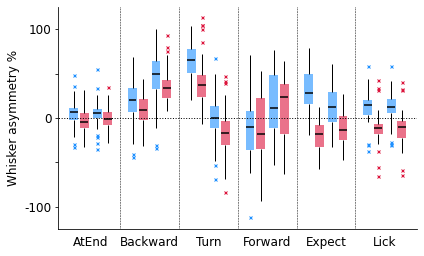

In [16]:
## Whisker

fig = plt.figure(figsize=(6, 3.5))
x = np.arange(len(epoch_analysis.STATES))
for i, state in enumerate(epoch_analysis.STATES):
    for half, baseoffset in ((1, -0.2), (2, 0.2)):
        basepos = i + baseoffset
        for turn, offset in (('Left', -.09), ('Right', .09)):
            b = BoxSummary.from_values(summary["whisker"][state][turn][half])
            plot_box_around(basepos + offset, b, boxwidth=.15, mcolor='k', color=colors[turn], 
                            ocolor=colors[turn], marker='x', markersize=3)
plt.vlines(x[1:]-.5, -1.5, 1.5, color='k', linewidth=.5, linestyles='dashed')
plt.hlines(0, x.min()-1, x.max()+1, color='k', linewidth=1, linestyles='dotted')
plt.xlim(x.min()-0.55, x.max()+0.55)
plt.ylim(-1.25, 1.25)
plt.xticks(np.arange(len(epoch_analysis.STATES)), epoch_analysis.STATES)
plt.yticks((-1, -0.5, 0, 0.5, 1), ("-100", "", "0", "", "100"))
plt.ylabel("Whisker asymmetry %", fontsize=12)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=12, bottom=False)
plt.subplots_adjust(bottom=.1, top=.98, left=.15, right=.98)

if saved == True:
    figpath = figdir / "whisker-asymmetry-boxplots-separate.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
    plt.show()

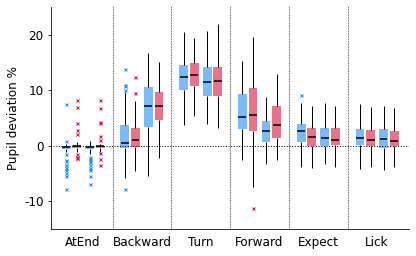

In [17]:
## Pupil

fig = plt.figure(figsize=(6, 3.5))
x = np.arange(len(epoch_analysis.STATES))
for i, state in enumerate(epoch_analysis.STATES):
    for half, baseoffset in ((1, -0.2), (2, 0.2)):
        basepos = i + baseoffset
        for turn, offset in (('Left', -.09), ('Right', .09)):
            b = BoxSummary.from_values(summary["eye"][state][turn][half])
            plot_box_around(basepos + offset, b, boxwidth=.15, mcolor='k', color=colors[turn], 
                            ocolor=colors[turn], marker='x', markersize=3)
plt.vlines(x[1:]-.5, -0.5, 0.5, color='k', linewidth=.5, linestyles='dashed')
plt.hlines(0, x.min()-1, x.max()+1, color='k', linewidth=1, linestyles='dotted')
plt.xlim(x.min()-0.55, x.max()+0.55)
plt.ylim(-0.15, 0.25)
plt.xticks(np.arange(len(epoch_analysis.STATES)), epoch_analysis.STATES)
plt.yticks((-0.1, 0, 0.1, 0.2), ("-10", "0", "10", "20"))
plt.ylabel("Pupil deviation %", fontsize=12)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=12, bottom=False)
plt.subplots_adjust(bottom=.1, top=.98, left=.15, right=.98)

if saved == True:
    figpath = figdir / "pupil-deviation-boxplots-separate.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
    plt.show()

### Plotting asymmetry altogether

Without distinction of left- or right- turning

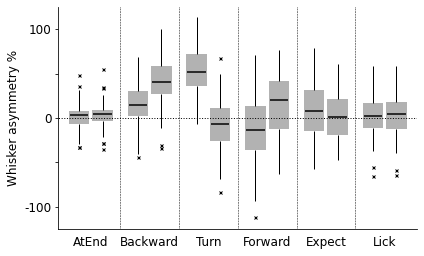

In [18]:
## Whisker

fig = plt.figure(figsize=(6, 3.5))
x = np.arange(len(epoch_analysis.STATES))
for i, state in enumerate(epoch_analysis.STATES):
    for half, baseoffset in ((1, -0.2), (2, 0.2)):
        b = BoxSummary.from_values(summary["whisker"][state]['Both'][half])
        plot_box_around(i + baseoffset, b, boxwidth=.35, mcolor='k', color=colors['Both'],
                            ocolor='k', marker='x', markersize=3)
plt.vlines(x[1:]-.5, -1.5, 1.5, color='k', linewidth=.5, linestyles='dashed')
plt.hlines(0, x.min()-1, x.max()+1, color='k', linewidth=1, linestyles='dotted')
plt.xlim(x.min()-0.55, x.max()+0.55)
plt.ylim(-1.25, 1.25)
plt.xticks(np.arange(len(epoch_analysis.STATES)), epoch_analysis.STATES)
plt.yticks((-1, -0.5, 0, 0.5, 1), ("-100", "", "0", "", "100"))
plt.ylabel("Whisker asymmetry %", fontsize=12)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=12, bottom=False)
plt.subplots_adjust(bottom=.1, top=.98, left=.15, right=.98)

if saved == True:
    figpath = figdir / "whisker-asymmetry-boxplots-merged.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
plt.show()

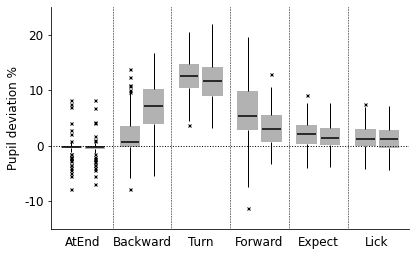

In [19]:
## Pupil

fig = plt.figure(figsize=(6, 3.5))
x = np.arange(len(epoch_analysis.STATES))
for i, state in enumerate(epoch_analysis.STATES):
    for half, baseoffset in ((1, -0.2), (2, 0.2)):
        b = BoxSummary.from_values(summary["eye"][state]['Both'][half])
        plot_box_around(i + baseoffset, b, boxwidth=.35, mcolor='k', color=colors['Both'],
                            ocolor='k', marker='x', markersize=3)
plt.vlines(x[1:]-.5, -0.3, 0.3, color='k', linewidth=.5, linestyles='dashed')
plt.hlines(0, x.min()-1, x.max()+1, color='k', linewidth=1, linestyles='dotted')
plt.xlim(x.min()-0.55, x.max()+0.55)
plt.ylim(-0.15, 0.25)
plt.xticks(np.arange(len(epoch_analysis.STATES)), epoch_analysis.STATES)
plt.yticks((-0.1, 0, 0.1, 0.2), ("-10", "0", "10", "20"))
plt.ylabel("Pupil deviation %", fontsize=12)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.tick_params(labelsize=12, bottom=False)
plt.subplots_adjust(bottom=.1, top=.98, left=.15, right=.98)

if saved == True:
    figpath = figdir / "pupil-asymmetry-boxplots-separate.png"
    if not figdir.exists():
        figdir.mkdir(parents=True)
    fig.savefig(str(figpath), dpi=300)
plt.show()

### Statistics

- vs. baseline (test if there is any asymmetry): Kruskal–Wallis test (with Dunn's _post-hoc_ pairwise tests) is used.
- left-turning vs right-turning: Mann-Whitney U-test is used.

In [20]:
def psign(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ", NS"

In [21]:
attr = "whisker"

print(f"## Kruskal-Wallis test\n")

for attr in ("whisker", "eye"):
    for turn in ("Left", "Right", "Both"):
        groups = []
        group_names = []
        group_N = []
        for state in epoch_analysis.STATES:
            for i, name in ((1, "1st half"), (2, "2nd half")):
                vals = summary[attr][state][turn][i]
                n    = vals.size
                groups.append(vals)
                group_names.append(f"{state} ({name}, N={n})")
                group_N.append(n)
        pairs = [(0, i) for i in range(1, len(groups))]

        results = kw_dunn.kw_dunn(groups, pairs=pairs)

        print(f"### {turn}-turning epochs, {attr}\n")
        print(f"p={results.p_omnibus:.5f}{psign(results.p_omnibus)}\n")
        for name, group in zip(group_names, groups):
            print(f"- {name}: median={np.median(group):.4f}, N={group.size}")
        print()
        
        print("#### Post-hoc pairwise tests\n")
        print(f"Compared with {group_names[0]}, with Bonferroni correction\n")
        for (_, i), result in results.pairwise.items():
            print(f"- {group_names[i]}: p={result.p_corrected:.5f}{psign(result.p_corrected)}")
        print(flush=True)

## Kruskal-Wallis test

### Left-turning epochs, whisker

p=0.00000***

- AtEnd (1st half, N=54): median=0.0667, N=54
- AtEnd (2nd half, N=54): median=0.0545, N=54
- Backward (1st half, N=54): median=0.2073, N=54
- Backward (2nd half, N=54): median=0.4922, N=54
- Turn (1st half, N=52): median=0.6509, N=52
- Turn (2nd half, N=52): median=0.0030, N=52
- Forward (1st half, N=63): median=-0.1053, N=63
- Forward (2nd half, N=63): median=0.1107, N=63
- Expect (1st half, N=51): median=0.2844, N=51
- Expect (2nd half, N=51): median=0.1260, N=51
- Lick (1st half, N=51): median=0.1425, N=51
- Lick (2nd half, N=51): median=0.1199, N=51

#### Post-hoc pairwise tests

Compared with AtEnd (1st half, N=54), with Bonferroni correction

- AtEnd (2nd half, N=54): p=1.00000, NS
- Backward (1st half, N=54): p=0.01769*
- Backward (2nd half, N=54): p=0.00000***
- Turn (1st half, N=52): p=0.00000***
- Turn (2nd half, N=52): p=1.00000, NS
- Forward (1st half, N=63): p=0.44151, NS
- Forward (2nd half, N=63): p

In [22]:
print("## Mann–Whitney U-test, left- vs. right-turning\n")
for attr in ("whisker", "eye"):
    lab = attr[0].upper() + attr[1:]
    print(f"### {lab}\n")
    for state in epoch_analysis.STATES:
        for i, name in ((1, "1st half"), (2, "2nd half")):
            v1 = summary[attr][state]["Left"][i]
            v2 = summary[attr][state]["Right"][i]
            p  = sstats.mannwhitneyu(v1, v2).pvalue
            print(f"- {state} ({name}): Left={np.median(v1):.4f} (N={v1.size}), Right={np.median(v2):.4f} (N={v2.size}), p={p:.5f}{psign(p)}")
    print(flush=True)

## Mann–Whitney U-test, left- vs. right-turning

### Whisker

- AtEnd (1st half): Left=0.0667 (N=54), Right=-0.0412 (N=36), p=0.00324**
- AtEnd (2nd half): Left=0.0545 (N=54), Right=-0.0131 (N=36), p=0.03191*
- Backward (1st half): Left=0.2073 (N=54), Right=0.0942 (N=36), p=0.01428*
- Backward (2nd half): Left=0.4922 (N=54), Right=0.3368 (N=36), p=0.00432**
- Turn (1st half): Left=0.6509 (N=52), Right=0.3656 (N=40), p=0.00001***
- Turn (2nd half): Left=0.0030 (N=52), Right=-0.1651 (N=40), p=0.00452**
- Forward (1st half): Left=-0.1053 (N=63), Right=-0.1770 (N=50), p=0.82388, NS
- Forward (2nd half): Left=0.1107 (N=63), Right=0.2326 (N=50), p=0.56126, NS
- Expect (1st half): Left=0.2844 (N=51), Right=-0.1800 (N=38), p=0.00000***
- Expect (2nd half): Left=0.1260 (N=51), Right=-0.1381 (N=38), p=0.00002***
- Lick (1st half): Left=0.1425 (N=51), Right=-0.1186 (N=36), p=0.00000***
- Lick (2nd half): Left=0.1199 (N=51), Right=-0.1070 (N=36), p=0.00000***

### Eye

- AtEnd (1st half): Left=-0.